In [272]:
# install fastkaggle if not available
try: import fastkaggle
except ModuleNotFoundError:
    %pip install -Uq fastkaggle

from fastkaggle import *

In [273]:
import matplotlib.pyplot as plt, seaborn as sns
from fastai.imports import *
from fastai.tabular.core import *

np.set_printoptions(linewidth=110)

In [274]:
comp = 'titanic'
path = setup_comp(comp, install='fastai')

path.ls(file_type='text')
df = pd.read_csv(path/'train.csv', low_memory=False)
tst_df = pd.read_csv(path/'test.csv', low_memory=False)

# EDA

### Fixing N/A

In [275]:
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [276]:
df.Cabin.isna().sum() / len(df)

0.7710437710437711

In [277]:
modes = df.mode().iloc[0]
modes

PassengerId                      1
Survived                       0.0
Pclass                         3.0
Name           Abbing, Mr. Anthony
Sex                           male
Age                           24.0
SibSp                          0.0
Parch                          0.0
Ticket                        1601
Fare                          8.05
Cabin                      B96 B98
Embarked                         S
Name: 0, dtype: object

In [278]:
df.fillna(modes, inplace=True)
tst_df.fillna(modes, inplace=True)

In [279]:
df.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

In [280]:

tst_df.isna().sum()

PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

What does the ideal person look like

In [281]:
survived_df = df[df.Survived == 1]
survived_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,342.000000,342.0,342.000000,342.000000,342.000000,342.000000,342.000000
mean,444.368421,1.0,1.950292,27.683246,0.473684,0.464912,48.395408
std,252.358840,0.0,0.863321,13.852214,0.708688,0.771712,66.596998
min,2.000000,1.0,1.000000,0.420000,0.000000,0.000000,0.000000
25%,250.750000,1.0,1.000000,21.000000,0.000000,0.000000,12.475000
50%,439.500000,1.0,2.000000,25.000000,0.000000,0.000000,26.000000
75%,651.500000,1.0,3.000000,35.000000,1.000000,1.000000,57.000000
max,890.000000,1.0,3.000000,80.000000,4.000000,5.000000,512.329200


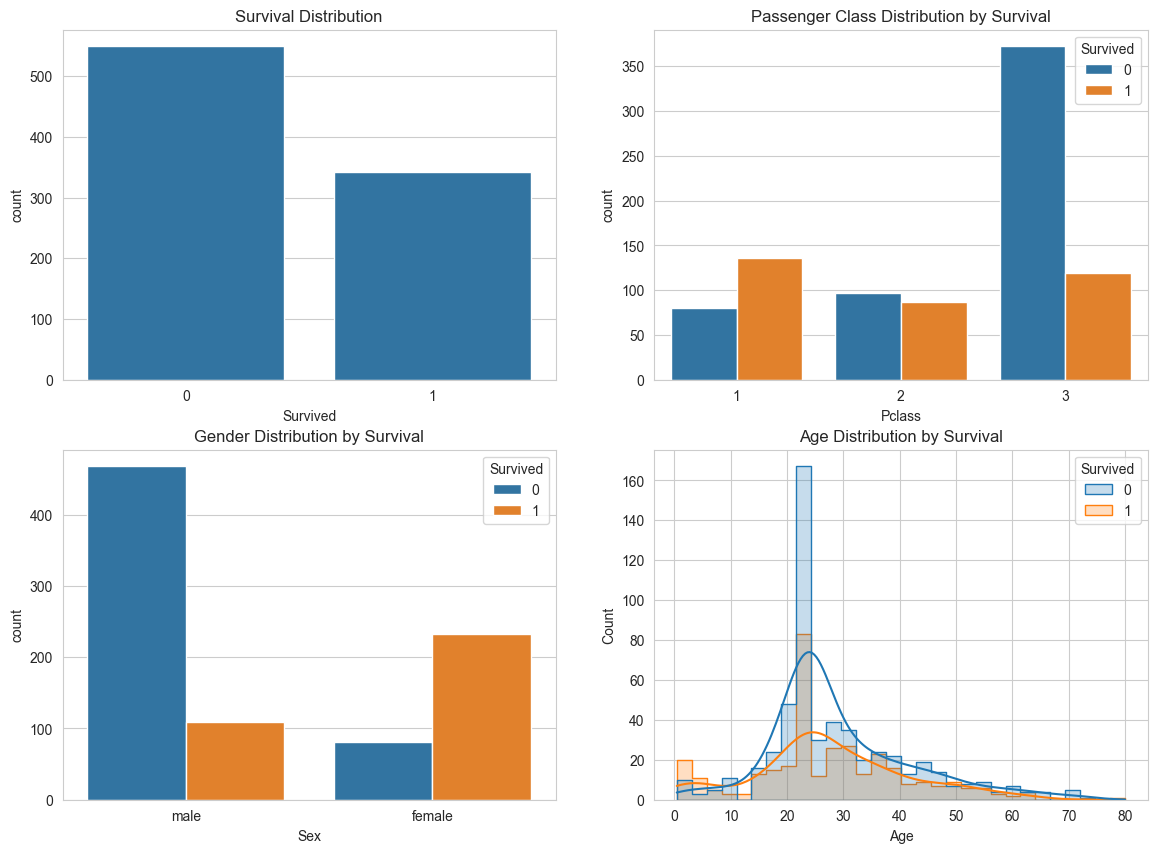

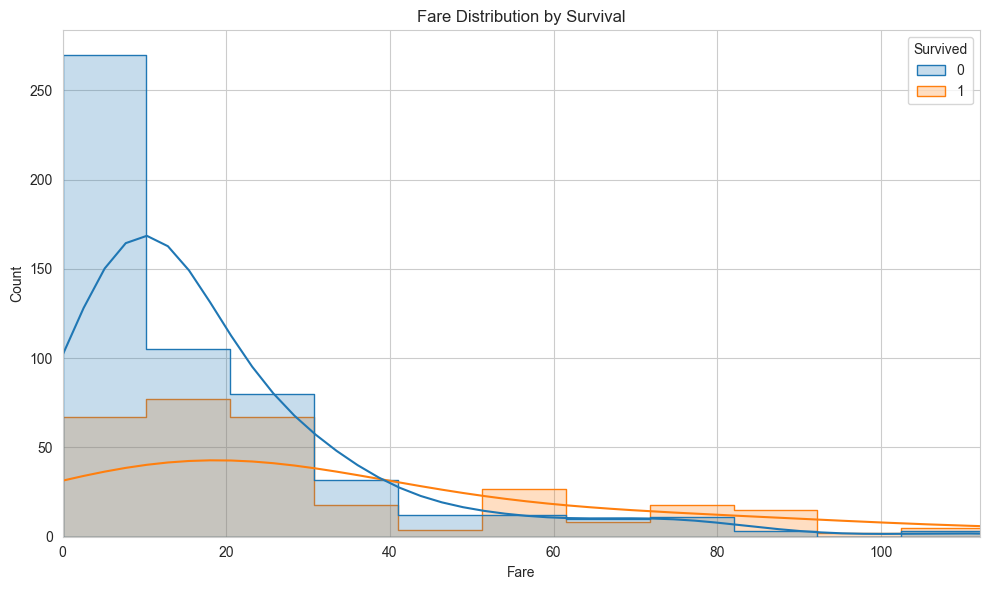

In [282]:
#Set the aesthetic style of the plots
sns.set_style("whitegrid")

#Initialize the figure
plt.figure(figsize=(14, 10))

#Plot distribution of key variables
plt.subplot(2, 2, 1)
sns.countplot(x='Survived', data=df)
plt.title('Survival Distribution')

plt.subplot(2, 2, 2)
sns.countplot(x='Pclass', hue='Survived', data=df)
plt.title('Passenger Class Distribution by Survival')

plt.subplot(2, 2, 3)
sns.countplot(x='Sex', hue='Survived', data=df)
plt.title('Gender Distribution by Survival')

plt.subplot(2, 2, 4)
sns.histplot(x='Age', hue='Survived', data=df, kde=True, element='step', bins=30)
plt.title('Age Distribution by Survival')


plt.figure(figsize=(10, 6))
sns.histplot(x='Fare', hue='Survived', data=df, kde=True, element='step', bins=50)
plt.title('Fare Distribution by Survival')
plt.xlim(0, df['Fare'].quantile(0.95))  # Limiting to 95th percentile for better visualization

plt.tight_layout()
plt.show()

# Variables

In [283]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

# Preprocessing

In [284]:
def classify_title():
    return {
        'nobility': ['don', 'sir', 'the countess', 'lady', 'dona', 'master'],
        'military': ['col', 'major', 'capt', 'sir'],
        'professional': ['dr', 'rev'],
        'male': ['mr', 'master'],
        'female': ['miss', 'mrs']
    }

def make_title(title):
    for key, values in classify_title().items():
        for value in values:
            value = value.lower()
            title = title.lower()
            if value in title or value + '.' in title:
                return key
    return 'na'

def add_features(df):
    df['LogFare'] = np.log1p(df['Fare'])
    df['Deck'] = df.Cabin.str[0].map(dict(A="ABC", B="ABC", C="ABC", D="DE", E="DE", F="FG", G="FG"))
    df['Family'] = df.SibSp+df.Parch
    df['Alone'] = df.Family==0
    df['TicketFreq'] = df.groupby('Ticket')['Ticket'].transform('count')
    # df['Title'] = df.Name.str.split(', ', expand=True)[1].str.split('.', expand=True)[0]
    df['Title'] = df.Name.map(make_title)

add_features(df)
add_features(tst_df)

In [285]:
from fastai.data.transforms import *

splits = RandomSplitter(seed=42)(df)
cats=["Sex","Pclass","Embarked","Deck", "Title"]
conts=['Age', 'SibSp', 'Parch', 'LogFare', 'Alone', 'TicketFreq', 'Family']
dep = 'Survived'

In [286]:
to = TabularPandas(
    df, splits=splits,
    procs = [Categorify, FillMissing, Normalize],
    cat_names=cats,
    cont_names=conts,
    y_names=dep,
)

len(to.train),len(to.valid)

(713, 178)

In [287]:
to.show()

,Sex,Pclass,Embarked,Deck,Title,Age,SibSp,Parch,LogFare,Alone,TicketFreq,Family,Survived
788,male,3,S,ABC,nobility,1.00,1.0,2.0,3.071535,0.0,2.0,3.0,1
525,male,3,Q,ABC,male,40.50,0.0,0.0,2.169054,1.0,1.0,0.0,0
821,male,3,S,ABC,male,27.00,0.0,0.0,2.268252,1.0,1.0,0.0,1
253,male,3,S,ABC,male,30.00,1.0,0.0,2.839078,0.0,2.0,1.0,0
374,female,3,S,ABC,female,3.00,3.0,1.0,3.094446,0.0,4.0,4.0,0
98,female,2,S,ABC,male,34.00,0.0,1.0,3.178054,0.0,2.0,1.0,1
215,female,1,C,DE,female,31.00,1.0,0.0,4.738608,0.0,3.0,1.0,1
313,male,3,S,ABC,male,28.00,0.0,0.0,2.185579,1.0,1.0,0.0,0
281,male,3,S,ABC,male,28.00,0.0,0.0,2.180892,1.0,1.0,0.0,0
305,male,1,S,ABC,nobility,0.92,1.0,2.0,5.027493,0.0,4.0,3.0,1


In [288]:
to.items.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,LogFare,Deck,Family,Alone,TicketFreq,Title
788,789,1,3,"Dean, Master. Bertram Vere",2,-2.092620,0.461591,2.034995,C.A. 2315,20.575001,B96 B98,3,0.130743,1,1.340794,-1.258305,0.155943,5
525,526,0,3,"Farrell, Mr. James",2,0.910475,-0.462887,-0.464491,367232,7.750000,B96 B98,2,-0.780172,1,-0.549752,0.794719,-0.580397,2
821,822,1,3,"Lulic, Mr. Nikola",2,-0.115899,-0.462887,-0.464491,315098,8.662500,B96 B98,3,-0.680046,1,-0.549752,0.794719,-0.580397,2


In [289]:
# we can check the mapping of the text to numbers, as you can see there is no particular order, unless you specified one
to.classes['Sex']

['#na#', 'female', 'male']

In [290]:
to.classes['Pclass']

['#na#', 1, 2, 3]

In [291]:
# verify numericalization
to.items.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,LogFare,Deck,Family,Alone,TicketFreq,Title
788,789,1,3,"Dean, Master. Bertram Vere",2,-2.092620,0.461591,2.034995,C.A. 2315,20.575001,B96 B98,3,0.130743,1,1.340794,-1.258305,0.155943,5
525,526,0,3,"Farrell, Mr. James",2,0.910475,-0.462887,-0.464491,367232,7.750000,B96 B98,2,-0.780172,1,-0.549752,0.794719,-0.580397,2
821,822,1,3,"Lulic, Mr. Nikola",2,-0.115899,-0.462887,-0.464491,315098,8.662500,B96 B98,3,-0.680046,1,-0.549752,0.794719,-0.580397,2


In [292]:
save_pickle(path/'to.pkl',to)
to = load_pickle(path/'to.pkl')

In [293]:
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y

# Decision Tree

let's try a small tree

In [294]:
from sklearn.tree import DecisionTreeClassifier
# make sure u got the preprocessing:
# everything numeric and filled missing values before trying to make a tree
tree_model = DecisionTreeClassifier(max_leaf_nodes=10)
tree_model.fit(xs, y);

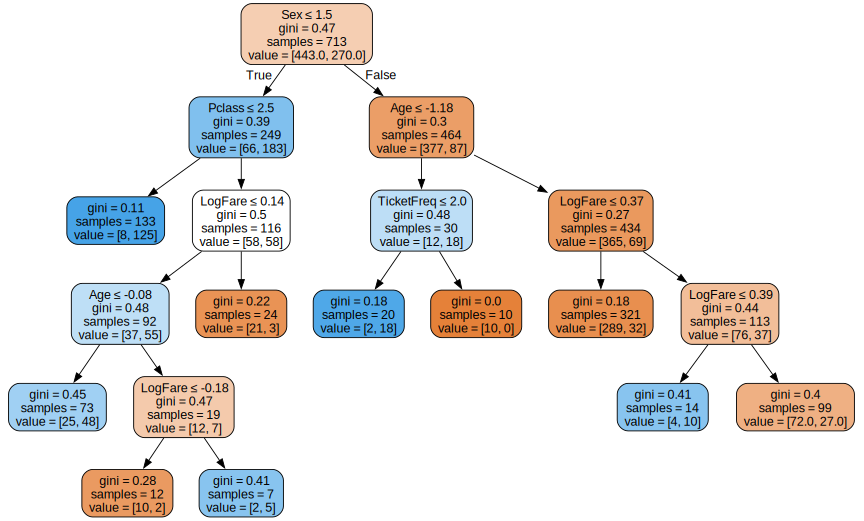

In [295]:
from sklearn.tree import export_graphviz
import graphviz

def draw_tree(t, df, size=10, ratio=0.6, precision=2, **kwargs):
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True, rounded=True,
                      special_characters=True, rotate=False, precision=precision, **kwargs)
    return graphviz.Source(re.sub('Tree {', f'Tree {{ size={size}; ratio={ratio}', s))

draw_tree(tree_model, xs, size=12)

/Users/cactus/miniconda3/envs/fastai/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


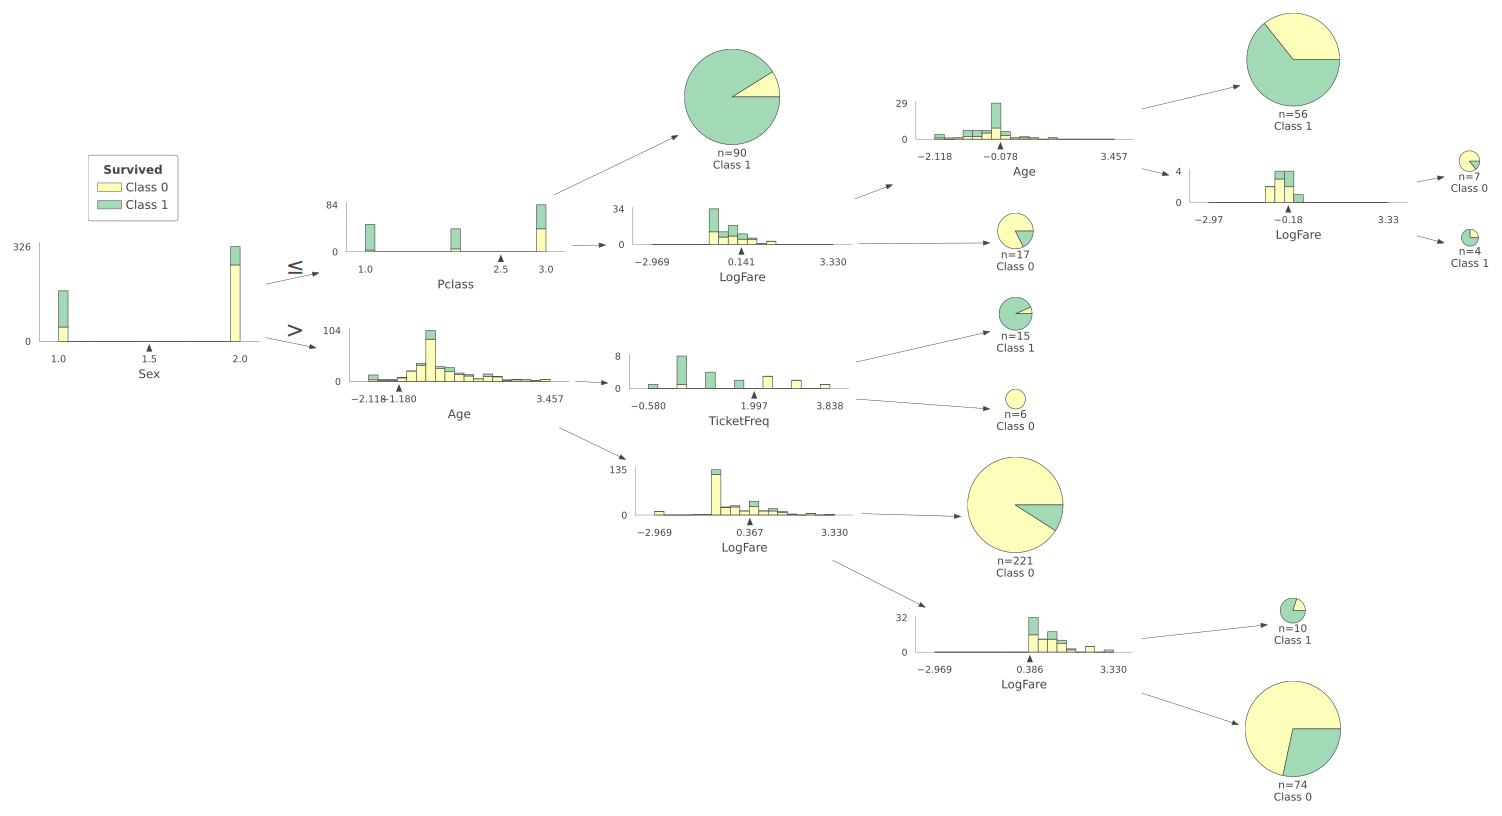

In [296]:
import dtreeviz

samp_idx = np.random.permutation(len(y))[:500]
viz_model=dtreeviz.model(tree_model,
X_train=xs.iloc[samp_idx],
y_train=y.iloc[samp_idx],
feature_names=xs.columns,
target_name=dep)

viz_model.view(fontname='DejaVu Sans', scale=1.6, label_fontsize=10, orientation='LR')

the full tree now

In [297]:
tree_model = DecisionTreeClassifier()
tree_model.fit(xs, y);

In [298]:
from sklearn.metrics import mean_absolute_error

def model_mse(m, xs, y): return mean_absolute_error(m.predict(xs), y)

In [299]:
# our model is perfect?
model_mse(tree_model, xs, y)

0.012622720897615708

In [300]:
# our model is perfect? NOPE!! we need to use validation set!
model_mse(tree_model, valid_xs, valid_y)

0.20224719101123595

We got 0 error in the training set but 35% on the validation set, that's the symptoms of overfitting!

Problem lies in how sklearn library works, if we don't define a minimum number of samples to have per leaves, we will get one leaf per row at the bottom of the tree.

That's the same as trying to classify every single row individually, but we don't want that, we want to classify rows into groups not rows into rows, so we want groups at the bottom of our tree.

In [301]:
tree_model = DecisionTreeClassifier(min_samples_leaf=25)
tree_model.fit(to.train.xs, to.train.y)
model_mse(tree_model, xs, y), model_mse(tree_model, valid_xs, valid_y)

(0.17251051893408134, 0.2303370786516854)

That's better, but error rate is still very high, let's move on to random forests

# Keeping Track Of Our Experiments

In [2]:
import pandas as pd

results_df = pd.DataFrame(columns=[''])

def track_results(experiment_name, result, reset=False):
    global results_df
    if reset:
        results_df = pd.DataFrame(columns=[''])
    if hasattr(result, '__dict__') and '__str__' in result.__dict__:
        results_df.loc[experiment_name] = result
    else:
        results_df.loc[experiment_name] = repr(result)
    return results_df

In [303]:
track_results('Tree', model_mse(tree_model, valid_xs, valid_y))

,Validation Error
Tree,0.230337


# Random Forest

In [304]:
from sklearn.ensemble import RandomForestClassifier

def random_forest(xs, y, n_estimators=100, min_samples_leaf=5):
    rf = RandomForestClassifier(n_estimators, min_samples_leaf=min_samples_leaf)
    rf.fit(xs, y);
    return rf
     

m = random_forest(xs, y);

In [305]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(valid_y, m.predict(valid_xs))

0.16292134831460675

In [306]:
track_results('RF 100', model_mse(m, valid_xs, valid_y))

,Validation Error
Tree,0.230337
RF 100,0.162921


In [307]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])
mean_absolute_error(preds.mean(0), valid_y)

/Users/cactus/miniconda3/envs/fastai/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
/Users/cactus/miniconda3/envs/fastai/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
/Users/cactus/miniconda3/envs/fastai/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
/Users/cactus/miniconda3/envs/fastai/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
/Users/cactus/miniconda3/envs/fastai/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
/Users/cactus/miniconda3/envs/fastai/lib/python3.11/site-packages/sklearn/base.py:486: UserWarn

0.2145505617977528

what if we add more trees?

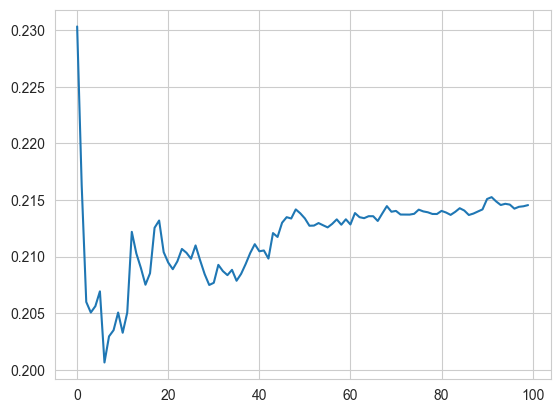

In [308]:
plt.plot([mean_absolute_error(preds[:i+1].mean(0), valid_y) for i in range(100)]);

In [309]:
# Seems like the sweet spot is around 30
# Let's try again
m = random_forest(xs, y, n_estimators=30);
model_mse(m, valid_xs, valid_y)

0.15730337078651685

In [310]:
track_results('RF 30', model_mse(m, valid_xs, valid_y))

,Validation Error
Tree,0.230337
RF 100,0.162921
RF 30,0.157303


# Model Interpretation

So 35 is not great, but we can use the model to get a first idea on the dataset, then we can decide what to further feature engineering we wanna do

In [311]:
def feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

fi = feat_importance(m, xs)
fi[:10]

,cols,imp
0,Sex,0.386359
8,LogFare,0.143889
1,Pclass,0.109730
5,Age,0.088547
4,Title,0.082313
10,TicketFreq,0.045849
11,Family,0.037748
3,Deck,0.034495
6,SibSp,0.026330
2,Embarked,0.021979


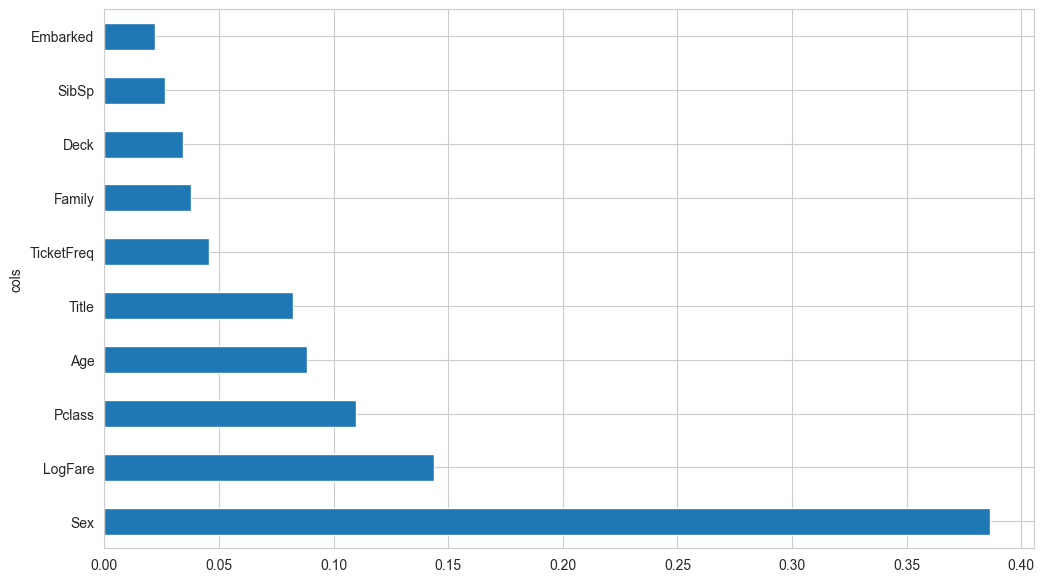

In [312]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi[:10]);

We can see that the most important factors are Sex, Fare, and Title

In [313]:
to_keep = fi[fi.imp>0.005].cols
len(to_keep)

12

In [314]:
# We can retrain our model using just this subset of the columns:
xs_imp = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]
m = random_forest(xs_imp, y);

In [315]:
model_mse(m, xs_imp, y), model_mse(m, valid_xs_imp, valid_y)

(0.11921458625525946, 0.16853932584269662)

In [316]:
track_results('Imp Cols', model_mse(m, valid_xs_imp, valid_y))

,Validation Error
Tree,0.230337
RF 100,0.162921
RF 30,0.157303
Imp Cols,0.168539


### Removing Redundants Features

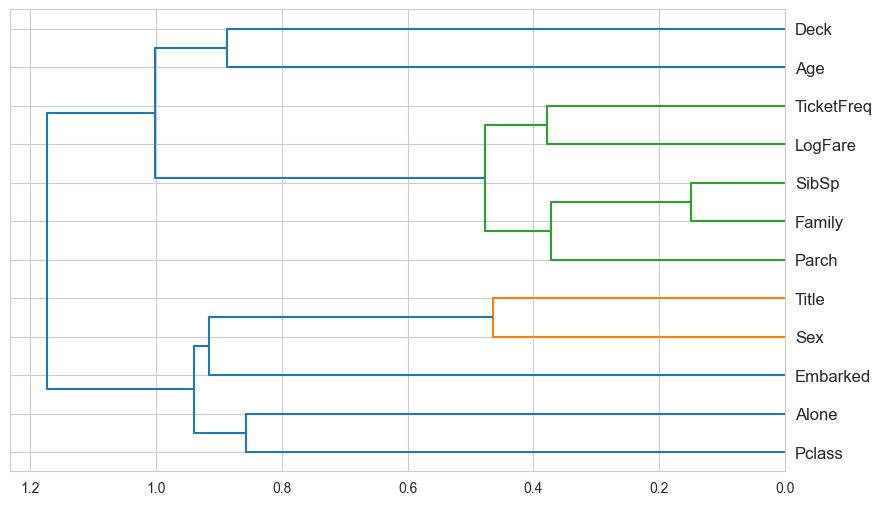

In [317]:
from scipy.cluster import hierarchy as hc

def cluster_columns(df, figsize=(10,6), font_size=12):
    corr = np.round(scipy.stats.spearmanr(df).correlation, 4)
    corr_condensed = hc.distance.squareform(1-corr)
    z = hc.linkage(corr_condensed, method='average')
    fig = plt.figure(figsize=figsize)
    hc.dendrogram(z, labels=df.columns, orientation='left', leaf_font_size=font_size)
    plt.show()

cluster_columns(xs_imp)

In [318]:
# Nothing special to remove, so for now we just do this
xs_final = xs_imp
valid_xs_final = valid_xs_imp

### Finding out Why Our Model Sucks

In [319]:
# 0.65% is quite a terrible number tho
# the reason is why do we have such a low score?
# Is that overfitting? Is that extrapolation problem? Is that out of domain data?

### Finding Out-of-Domain Data

We need to train a random forest, not to find a dependent variable, but to find out if the row belongs to the training set or validation set

In [320]:
df_dom = pd.concat([xs_final, valid_xs_final])
is_valid = np.array([0]*len(xs_final) + [1]*len(valid_xs_final))
df_dom.shape, is_valid.shape

((891, 12), (891,))

In [321]:
m = random_forest(df_dom, is_valid);
feat_importance(m, df_dom)[:6]

,cols,imp
1,LogFare,0.303518
3,Age,0.276643
5,TicketFreq,0.058865
4,Title,0.057391
2,Pclass,0.055009
9,Embarked,0.054999


In [322]:
# it seems that age and fare are the biggest difference between the validation and training set

# let's establish a baseline on the rmse
m = random_forest(xs_final, y)
print('orig', model_mse(m, valid_xs_final, valid_y))

# then we remove each column to see the impact on the rmse
for c in ('LogFare','Age'):
    m = random_forest(xs_final.drop(c,axis=1), y)
    print(c, model_mse(m, valid_xs_final.drop(c,axis=1), valid_y))

orig 0.15730337078651685
LogFare 0.16292134831460675
Age 0.1797752808988764


In [323]:
# It looks like we should be able to remove LogFare but NOT AGE
# let's see what's the accuracy after removing these columns
time_vars = ['LogFare']
xs_final_time = xs_final.drop(time_vars, axis=1)
valid_xs_time = valid_xs_final.drop(time_vars, axis=1)

m = random_forest(xs_final_time, y)
model_mse(m, valid_xs_time, valid_y)

0.16853932584269662

we even improved a bit! so we can go on without these two columns

In [324]:
track_results('Minus Useless Cols', model_mse(m, valid_xs_time, valid_y))

,Validation Error
Tree,0.230337
RF 100,0.162921
RF 30,0.157303
Imp Cols,0.168539
Minus Useless Cols,0.168539


In [351]:
xs_final_time.columns

Index(['Sex', 'Pclass', 'Age', 'Title', 'TicketFreq', 'Family', 'Deck',
       'SibSp', 'Embarked', 'Alone', 'Parch'],
      dtype='object')

In [352]:
to_tst = to.train.new(tst_df)
to_tst.process()

# we need to keep the exact same order and columns as we used to trained our model
xs = xs[xs_final_time.columns]
xs

,Sex,Pclass,Age,Title,TicketFreq,Family,Deck,SibSp,Embarked,Alone,Parch
0,2,3,0.454309,2,-0.580397,-0.549752,1,-0.462887,2,0.794719,-0.464491
1,1,3,1.404656,2,-0.580397,0.080430,1,0.461591,3,-1.258305,-0.464491
2,2,2,2.545072,2,-0.580397,-0.549752,1,-0.462887,2,0.794719,-0.464491
3,2,3,-0.115899,2,-0.580397,-0.549752,1,-0.462887,3,0.794719,-0.464491
4,1,3,-0.496038,2,-0.580397,0.710612,1,0.461591,3,-1.258305,0.785252
...,...,...,...,...,...,...,...,...,...,...,...
413,2,3,-0.343982,2,-0.580397,-0.549752,1,-0.462887,3,0.794719,-0.464491
414,1,1,0.796434,5,-0.580397,-0.549752,1,-0.462887,1,0.794719,-0.464491
415,2,3,0.758420,2,-0.580397,-0.549752,1,-0.462887,3,0.794719,-0.464491
416,2,3,-0.343982,2,-0.580397,-0.549752,1,-0.462887,3,0.794719,-0.464491


In [353]:
def subm(preds, suff):
    tst_df['Survived'] = preds
    sub_df = tst_df[['PassengerId','Survived']]
    sub_df.to_csv(f'sub-{suff}.csv', index=False)

subm(m.predict(xs), 'rf')